# New Section

In [ ]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import seaborn as sns

from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
AUTOTUNE = tf.data.AUTOTUNE
from sklearn.metrics import confusion_matrix


print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.19.0
TensorFlow Hub version: 0.16.1
GPU is available


In [2]:
!rm -rf /root/.keras/datasets/*

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
num_classes = 5     # تنظیم کن مطابق دیتاستت
EPOCHS = 15          # فاز اول (train head)


In [3]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

print(f"Data directory: {data_dir}")

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Data directory: /root/.keras/datasets/flower_photos


In [4]:


IMAGE_SIZE = (224, 224)
import pathlib
data_dir = pathlib.Path(data_dir) / "flower_photos"
def build_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset=subset,
        label_mode="categorical",  # خروجی لِیبِل ها به صورت one-hot است
        seed=123,                  # برای پایداری در تقسیم داده‌ها
        image_size=IMAGE_SIZE,     # اندازه ثابت برای همه تصاویر
        batch_size=BATCH_SIZE             # اول هر تصویر یک به یک خوانده می‌شود
    )

train_ds = build_dataset("training")
val_ds = build_dataset("validation")

# نمایش تعداد کلاس‌ها
class_names = train_ds.class_names
print(f"Classes: {class_names}")


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [5]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
             # تعداد دوره‌های آموزش
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,      # حذف لایه آخر کلاس‌بندی اصلی
    weights='imagenet'      # بارگذاری وزن‌های pretrained
)

base_model.trainable = False  # اول فقط این لایه‌ها فریز میشن (آپدیت نمیشن)

# 6. اضافه کردن لایه‌های جدید برای طبقه‌بندی روی مدل پایه
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x=data_augmentation(inputs)
x = base_model(inputs, training=False)  # با training=False برای اینکه BatchNorm حالت inference باشه
x = layers.GlobalAveragePooling2D()(x) # تبدیل فیچر مپ به وکتور یک بعدی
x = layers.Dropout(0.2)(x)              # دراپ‌اوت برای جلوگیری از overfitting
outputs = layers.Dense(num_classes, activation='softmax')(x)  # لایه آخر کلاس‌بندی

model = keras.Model(inputs, outputs)
model.summary()
# 7. کامپایل مدل
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# تنظیم EarlyStopping با patience بیشتر
early_stopping_tuned = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # صبر بیشتر برای جلوگیری از توقف زودهنگام
    restore_best_weights=True # بازیابی بهترین وزن‌ها بر اساس کمترین validation loss
)


history = model.fit(
     train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_tuned] # استفاده از early stopping


)

# ارزیابی
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.2f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 53s 86ms/step - accuracy: 0.3902 - loss: 1.5736 - val_accuracy: 0.6213 - val_loss: 1.0387
Epoch 2/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6175 - loss: 1.0183 - val_accuracy: 0.7275 - val_loss: 0.8097
Epoch 3/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6902 - loss: 0.8174 - val_accuracy: 0.7793 - val_loss: 0.6853
Epoch 4/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7518 - loss: 0.6933 - val_accuracy: 0.8106 - val_loss: 0.6098
Epoch 5/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7808 - loss: 0.6314 - val_accuracy: 0.8188 - val_loss: 0.5643
Epoch 6/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7960 - loss: 0.5672 - val_accuracy: 0.8351 - val_loss: 0.5260
Epoch 7/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8040 - loss: 0.5344 - val_accuracy: 0.8447 - val_loss: 0.4967
Epoch 8/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8254 - loss: 0.4987 - val_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

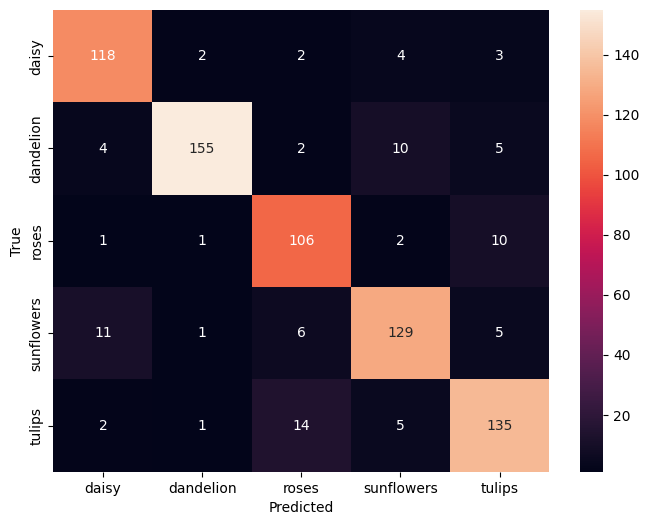

In [ ]:
# گرفتن همه‌ی پیش‌بینی‌ها روی مجموعه‌ی validation
y_true = []
y_pred = []
for images, labels in val_ds:   # val_ds باید batch شده باشه
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

# رسم heatmap confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


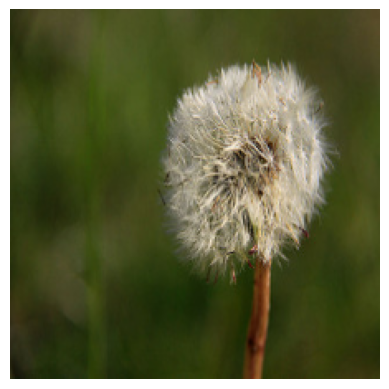

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
True label: dandelion
Predicted label: dandelion
prediction_scores   [[1.9833562e-04 9.9957949e-01 5.3404729e-05 9.7193028e-05 7.1671595e-05]]
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
True index: 1 -> dandelion
Predicted index: 1 -> dandelion
One-hot true label: [0. 1. 0. 0. 0.]


In [9]:

x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])
print("prediction_scores  ", prediction_scores)
print("Class names:", class_names)
print("True index:", true_index, "->", class_names[true_index])
print("Predicted index:", np.argmax(prediction_scores), "->", class_names[np.argmax(prediction_scores)])
print("One-hot true label:", y[0].numpy())  # اگر y[0] one-hot label است


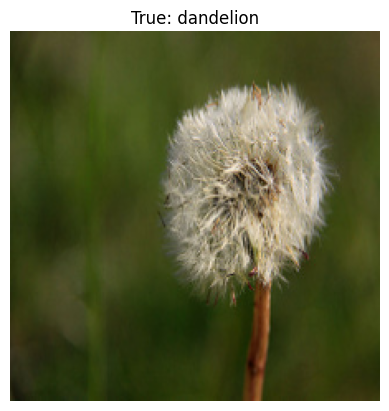

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted: dandelion
Prediction scores: [[1.9833562e-04 9.9957949e-01 5.3404729e-05 9.7193028e-05 7.1671595e-05]]


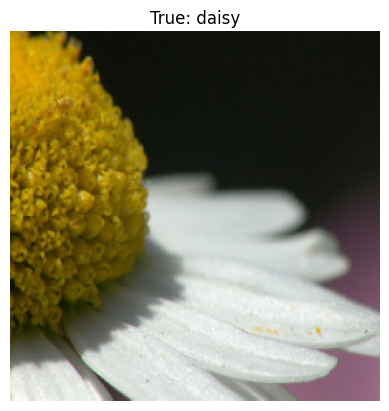

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: sunflowers
Prediction scores: [[0.3435222  0.09621687 0.02629352 0.41306737 0.12090001]]


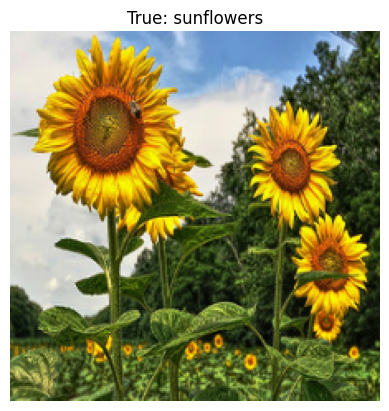

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted: sunflowers
Prediction scores: [[4.4185929e-03 6.2907776e-03 5.3545140e-04 9.8751312e-01 1.2421245e-03]]


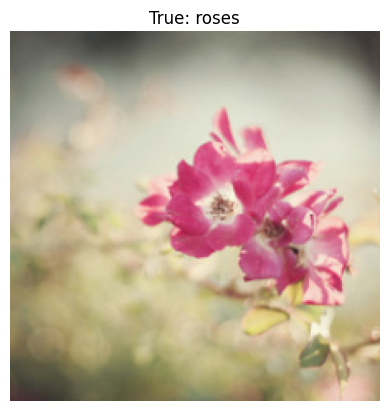

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: roses
Prediction scores: [[0.00230164 0.00574083 0.92194897 0.03032161 0.03968692]]


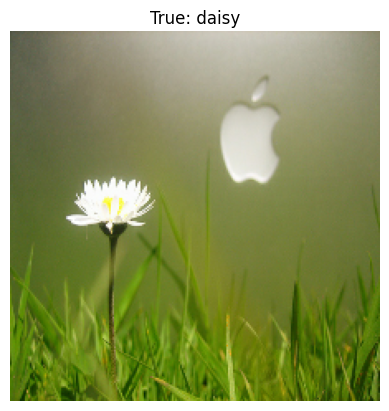

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted: daisy
Prediction scores: [[0.74094504 0.17145851 0.02413444 0.02474643 0.03871558]]


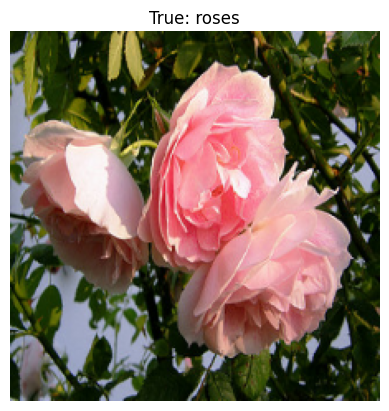

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted: roses
Prediction scores: [[1.1742570e-05 4.1868584e-06 9.9779022e-01 7.2133240e-05 2.1217484e-03]]


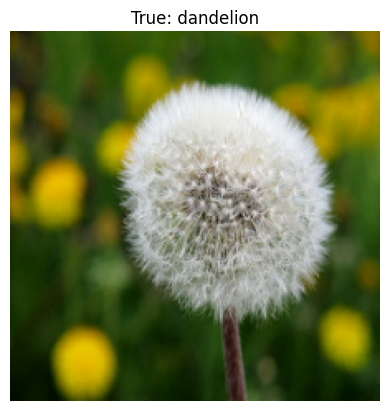

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted: dandelion
Prediction scores: [[9.6178631e-04 9.9819863e-01 8.3935221e-05 5.2333396e-04 2.3225861e-04]]


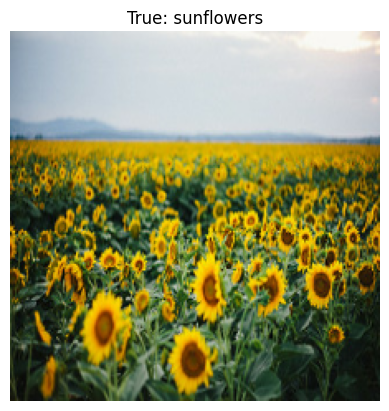

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted: sunflowers
Prediction scores: [[3.0150316e-03 7.3479110e-04 1.2913788e-03 8.9796329e-01 9.6995525e-02]]


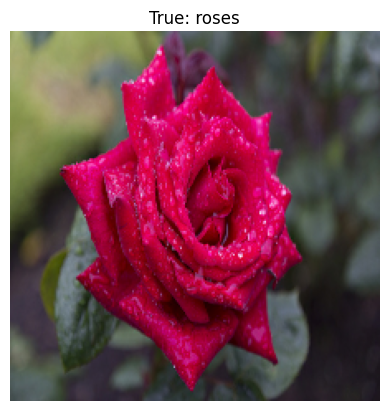

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: roses
Prediction scores: [[1.4627446e-05 1.0541122e-05 9.9830329e-01 4.4170385e-05 1.6273858e-03]]


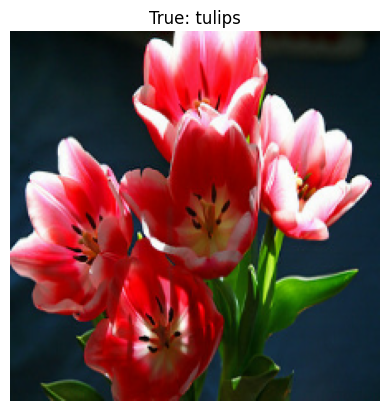

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: tulips
Prediction scores: [[0.01407032 0.00642169 0.11598951 0.01010375 0.8534148 ]]


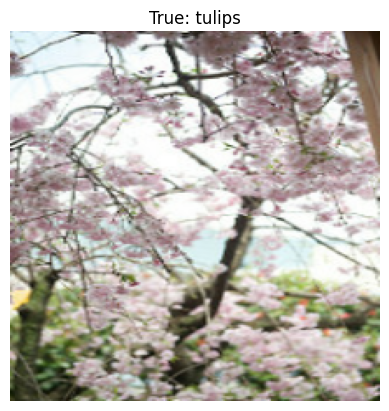

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted: roses
Prediction scores: [[0.08423416 0.28758717 0.5075522  0.06466736 0.05595906]]


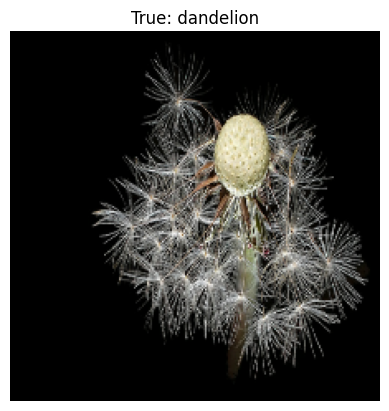

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted: dandelion
Prediction scores: [[3.5540975e-04 9.8131782e-01 6.0881688e-03 1.0793208e-02 1.4452796e-03]]


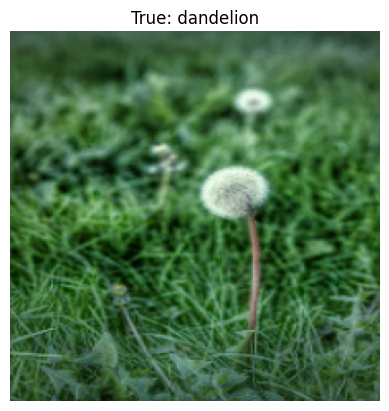

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted: dandelion
Prediction scores: [[0.00237612 0.9903113  0.00238818 0.00314302 0.0017814 ]]


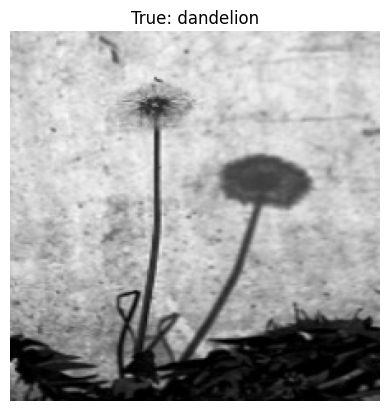

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted: dandelion
Prediction scores: [[0.00286847 0.9575153  0.01639861 0.00978178 0.01343585]]


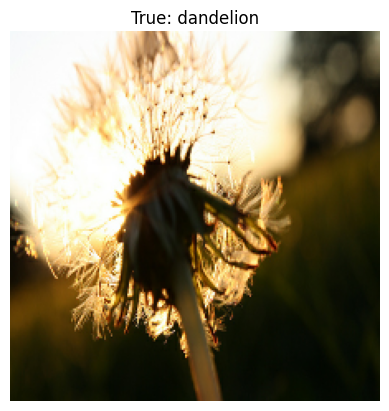

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted: dandelion
Prediction scores: [[6.8882652e-02 8.6644572e-01 5.7310192e-04 6.2944241e-02 1.1542632e-03]]


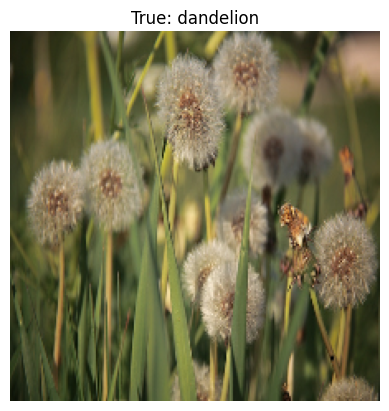

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted: dandelion
Prediction scores: [[7.4546084e-02 9.0428191e-01 3.3162502e-04 1.3297732e-02 7.5426782e-03]]


In [10]:
for images, labels in val_ds.take(1):  # گرفتن یک batch از مجموعه validation
    for i in range(len(images)):       # یا تعداد دلخواه مثلا 10 تا اول
        image = images[i]
        true_label = np.argmax(labels[i].numpy())

        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(f"True: {class_names[true_label]}")
        plt.show()

        prediction_scores = model.predict(np.expand_dims(image, axis=0))
        predicted_label = np.argmax(prediction_scores)

        print(f"Predicted: {class_names[predicted_label]}")
        print(f"Prediction scores: {prediction_scores}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

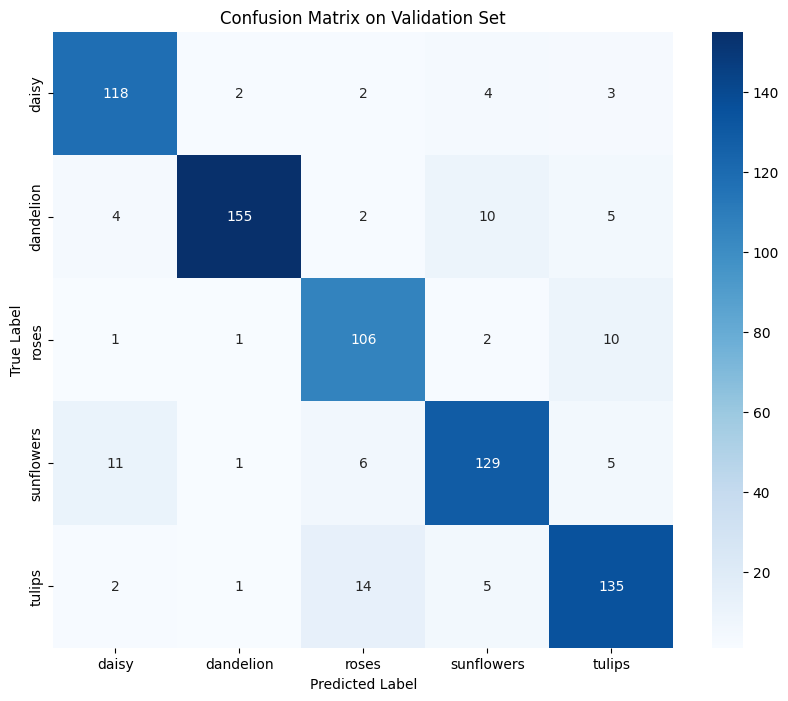

              precision    recall  f1-score   support

       daisy       0.87      0.91      0.89       129
   dandelion       0.97      0.88      0.92       176
       roses       0.82      0.88      0.85       120
  sunflowers       0.86      0.85      0.85       152
      tulips       0.85      0.86      0.86       157

    accuracy                           0.88       734
   macro avg       0.87      0.88      0.87       734
weighted avg       0.88      0.88      0.88       734



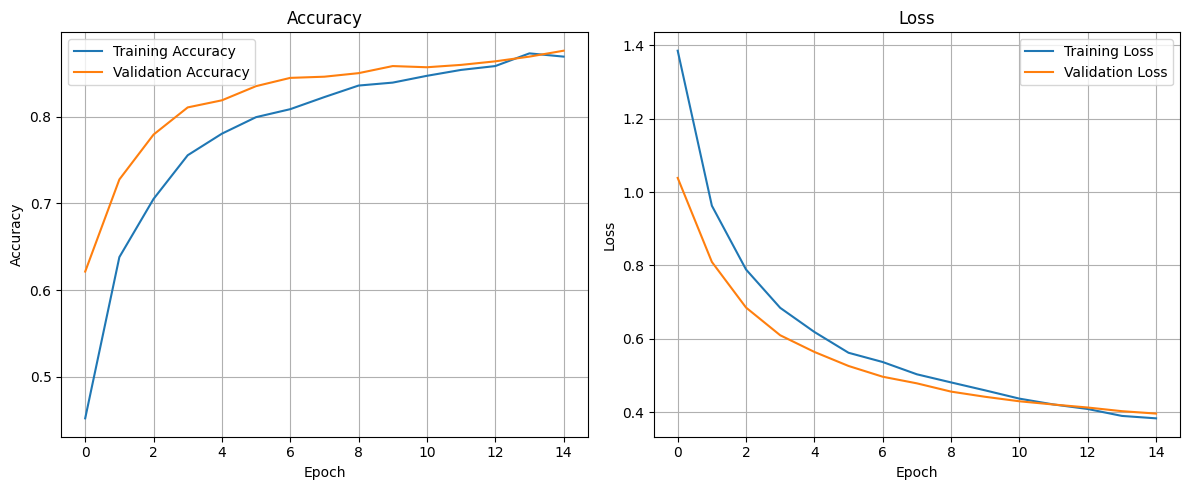

In [12]:

from sklearn.metrics import confusion_matrix, classification_report

# جمع‌آوری تمام پیش‌بینی‌ها و لیبل‌های واقعی از validation dataset
y_true_val = []
y_pred_val = []

for images, labels in val_ds:
    # مدل پیش‌بینی می‌کند، خروجی softmax است
    predictions = model.predict(images)

    # گرفتن لیبل‌های پیش‌بینی شده (با بیشترین احتمال)
    predicted_labels = np.argmax(predictions, axis=1)
    y_pred_val.extend(predicted_labels)

    # گرفتن لیبل‌های واقعی
    true_labels = np.argmax(labels.numpy(), axis=1)
    y_true_val.extend(true_labels)

print("Predictions generated. Calculating confusion matrix and report...")

# محاسبه ماتریس درهم‌ریختگی
cm = confusion_matrix(y_true_val, y_pred_val)

# نمایش heatmap با seaborn
plt.figure(figsize=(10, 8)) # اندازه نمودار را کمی بزرگتر می‌کنیم
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label') # برچسب محور X
plt.ylabel('True Label') # برچسب محور Y
plt.title('Confusion Matrix on Validation Set') # عنوان نمودار
plt.show()

# نمایش گزارش طبقه‌بندی (classification report)
print(classification_report(y_true_val, y_pred_val, target_names=class_names))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()